In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the data
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv("./test.csv")


In [3]:
# Set up the data
# Split the 42,000 training sample further into a training set and a cross-validation set.
train_num = int(42000 / 5 * 4)

y_train = train_data['label'].values[:train_num]
X_train = train_data.drop(columns=['label']).values[:train_num] /255
y_valid = train_data['label'].values[train_num:]
X_valid = train_data.drop(columns=['label']).values[train_num:] /255

X_test = test_data.values/255

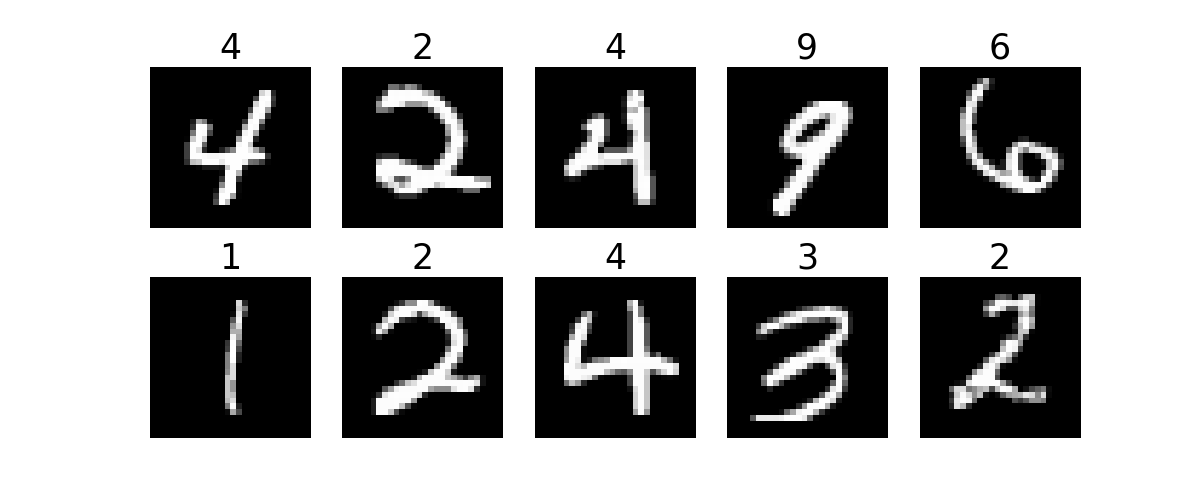

In [4]:
%matplotlib widget
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,X_train.shape[0],size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [5]:
# relu activation function
# THE fastest vectorized implementation for ReLU
def relu(x):
    x[x<0]=0
    return x

def softmax(X_in, weights):
    '''
    Un-used cell for demo
    activation function for the last FC layer: softmax function 
    Output: K probabilities represent an estimate of P(y=k|X_in;weights) for k=1,...,K
    the weights has shape (n, K)
    n: the number of features X_in has
    n = X_in.shape[1]
    K: the number of classes
    K = 10
    '''
    s = np.exp(np.matmul(X_in,weights))
    total = np.sum(s, axis=1).reshape(-1,1)
    return s / total

#def sigmoid(self, x):
   # sig = 1/(1+np.exp(-x))
   # return sig, sig *(1-sig)

#def tanha(self,x):
   # tan=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
   # return tan, 1-np.square(tan)

In [6]:
def h(X,W,b):
    '''
    Hypothesis function: simple FNN with 1 hidden layer
    Layer 1: input
    Layer 2: hidden layer, with a size implied by the arguments W[0], b
    Layer 3: output layer, with a size implied by the arguments W[1]
    '''
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    
    # layer 2 activation
    a2 = relu(z1)
    # layer 2 (hidden layer) -> layer 3 (hidden layer)
    z2 = np.matmul(a2, W[1])
    
    # layer 3 activation
    a3 = relu(z2)
    # layer 3 (hidden layer) -> layer 4 (output layer)
    z3 = np.matmul(a3, W[2])
    
    # output layer
    s = np.exp(z3)
    total = np.sum(s, axis=1).reshape(-1,1)
    a4 = s/total
    
    # the output is a probability for each sample
    return a4

In [7]:
def loss(y_pred,y_true):
    '''
    Loss function: cross entropy with an L^2 regularization
    y_true: ground truth, of shape (N, )
    y_pred: prediction made by the model, of shape (N, K) 
    N: number of samples in the batch
    K: global variable, number of classes
    '''
    global K 
    K = 10
    N = len(y_true)
    # loss_sample stores the cross entropy for each sample in X
    # convert y_true from labels to one-hot-vector encoding
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)
    # loss_sample is a dimension (N,) array
    # for the final loss, we need take the average
    return -np.mean(loss_sample)

In [8]:
def backprop(W,b,X,y,alpha=1e-4):
    '''
    Step 1: explicit forward pass h(X;W,b)
    Step 2: backpropagation for dW and db
    '''
    K = 10
    N = X.shape[0]
    
    ### Step 1:
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    
    # layer 2 activation
    a2 = relu(z1)
    # layer 2 (hidden layer) -> layer 3 (hidden layer)
    z2 = np.matmul(a2, W[1])
    
    # layer 3 activation  [add one more layer]
    a3 = relu(z2)
    # layer 3 (hidden layer) -> layer 4 (output layer)
    z3 = np.matmul(a3, W[2])
    
    # output layer
    s = np.exp(z3)
    total = np.sum(s, axis=1).reshape(-1,1)
    a4 = s/total
    
    ### Step 2:
    
    # layer 3->layer 4 weights' derivative
    # delta2 is \partial L/partial z2, of shape (N,K)
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta3 = (a4 - y_one_hot_vec)
    grad_W2 = np.matmul(a3.T, delta3)
    
    # layer 2->layer 3 weights' derivative
    # delta2 is \partial L/partial z2, just for ReLU activation function
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta2 = np.matmul(delta3, W[2].T)*(z2>0)
    grad_W1 = np.matmul(a2.T, delta2)
    
    # layer 1->layer 2 weights' derivative
    # delta1 is \partial a2/partial z1
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)
    
   
    # no derivative for layer 1
    
    # the alpha part is the derivative for the regularization
    # regularization = 0.5*alpha*(np.sum(W[1]**2) + np.sum(W[0]**2))
    
    
    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1], grad_W2/N + alpha*W[2]]
    db = [np.mean(delta1, axis=0)]
    # dW[0] is W[0]'s derivative, and dW[1] is W[1]'s derivative; similar for db
    return dW, db

In [9]:
#Using mini-batch SGD to train the network
def main(epochs, batch_size):
    # gW0 = gW1 = gW2 = gb0 = 1

    # for each epoch
    train_loss_list = []
    train_accu_list = []
    vaild_loss_list = []
    vaild_accu_list = []
    indx = np.arange(X_train.shape[0])
    
    for i in range(epochs):
        print('Runing epochs %i'%(i + 1), end='\r')
        
        start_ind = 0
        Loss = 0
        gW0 = gW1 = gW2 = gb0 = 1

        num_batches = 0
        exit_cond = False
        
        np.random.shuffle(indx)

        while True:
            t = i + 1
            if start_ind + batch_size >= X_train.shape[0]:
                exit_cond = True
                batch = X_train[indx[start_ind:]]
                batch_l = y_train[indx[start_ind:]]
            else:
                batch = X_train[indx[start_ind:start_ind + batch_size]]
                batch_l = y_train[indx[start_ind:start_ind + batch_size]]

            dW, db = backprop(W,b,batch,batch_l,alpha)

            gW0 = gamma*gW0 + (1-gamma)*np.sum(dW[0]**2)
            etaW0 = eta/np.sqrt(gW0 + eps)
            W[0] -= etaW0 * dW[0]

            gW1 = gamma*gW1 + (1-gamma)*np.sum(dW[1]**2)
            etaW1 = eta/np.sqrt(gW1 + eps)
            W[1] -= etaW1 * dW[1]

            gW2 = gamma*gW2 + (1-gamma)*np.sum(dW[2]**2)
            etaW2 = eta/np.sqrt(gW2 + eps)
            W[2] -= etaW2 * dW[2]

            gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
            etab0 = eta/np.sqrt(gb0 + eps)
            b[0] -= etab0 * db[0]

            start_ind += batch_size
            num_batches += 1
            batch = batch_l = None
            if exit_cond:
                break

        # print('final:')
        # sanity check 1
        # print('valid:')
        y_pred_valid = h(X_valid,W,b)
        loss_value_vaild = loss(y_pred_valid,y_valid)
        accu_valid = np.mean(np.argmax(y_pred_valid, axis=1) == y_valid)

        vaild_loss_list.append(loss_value_vaild.copy())
        vaild_accu_list.append(accu_valid.copy())

        # print('train:')
        y_pred_train = h(X_train,W,b)
        loss_value_train = loss(y_pred_train,y_train)
        accu_train = np.mean(np.argmax(y_pred_train, axis=1) == y_train)
        train_loss_list.append(loss_value_train.copy())
        train_accu_list.append(accu_train.copy())
        
        if i % 10 == 0:
            print('valid:')
            print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(loss_value_vaild))
            print("Training accuracy after", i+1, "iterations is {:.4%}".format(accu_valid))   
            print('train:')
            print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(loss_value_train))
            print("Training accuracy after", i+1, "iterations is {:.4%}".format(accu_train))
            # sanity check 2
            print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
                  .format(gW0, gW1, gb0, etaW0, etaW1, etab0))
            # sanity check 3
            print("|dW0|={:.5f} |dW1|={:.5f} |dW2|={:.5f} |db0|={:.5f}"
                 .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(dW[2]), np.linalg.norm(db[0])), "\n")
    print('final:')
    print('valid:')
    print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(loss_value_vaild))
    print("Training accuracy after", i+1, "iterations is {:.4%}".format(accu_valid))   
    print('train:')
    print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(loss_value_train))
    print("Training accuracy after", i+1, "iterations is {:.4%}".format(accu_train))
    # sanity check 2
    print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
        .format(gW0, gW1, gb0, etaW0, etaW1, etab0))
    # sanity check 3
    print("|dW0|={:.5f} |dW1|={:.5f} |dW2|={:.5f} |db0|={:.5f}"
            .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(dW[2]), np.linalg.norm(db[0])), "\n")
        
    return vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list

In [10]:
#Validate the performance of the model
#%%time
# batch chage
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop

epochs = 40
batch_size = 128

n_H1 = 256 # number of neurons in the hidden layer
n_H2 = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

np.random.seed(1127)
W = [1e-1*np.random.randn(n, n_H1), 1e-1*np.random.randn(n_H1, n_H2), 1e-1*np.random.randn(n_H2, K)]
b = [np.random.randn(n_H1)]

vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list = main(epochs, batch_size)

valid: epochs 1
Cross-entropy loss after 1 iterations is 0.162621
Training accuracy after 1 iterations is 94.8690%
train:
Cross-entropy loss after 1 iterations is 0.14066233
Training accuracy after 1 iterations is 95.7857%
gW0=0.4965 gW1=0.3718 gb0=0.0787
etaW0=0.7089 etaW1=0.8188 etab0=1.7715
|dW0|=0.35539 |dW1|=0.24826 |dW2|=0.20154 |db0|=0.04384 

valid: epochs 11
Cross-entropy loss after 11 iterations is 0.24081313
Training accuracy after 11 iterations is 94.5833%
train:
Cross-entropy loss after 11 iterations is 0.12664095
Training accuracy after 11 iterations is 96.6131%
gW0=0.1554 gW1=0.1099 gb0=0.0722
etaW0=1.2642 etaW1=1.5014 etab0=1.8486
|dW0|=0.91025 |dW1|=0.73125 |dW2|=0.30838 |db0|=0.10204 

valid: epochs 21
Cross-entropy loss after 21 iterations is 0.27867738
Training accuracy after 21 iterations is 94.7143%
train:
Cross-entropy loss after 21 iterations is 0.12435065
Training accuracy after 21 iterations is 97.5238%
gW0=0.1163 gW1=0.0923 gb0=0.0717
etaW0=1.4602 etaW1=1.636

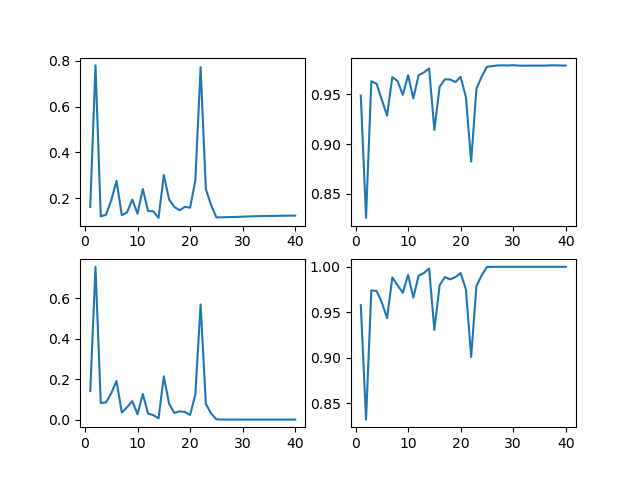

In [11]:
%matplotlib widget
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_loss_list)
axs[0, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_accu_list)
axs[1, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_loss_list)
axs[1, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_accu_list)

In [14]:
#Change the batch size from 128 to 256

# batch chage
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop

epochs = 40
batch_size = 256

n_H1 = 256 # number of neurons in the hidden layer
n_H2 = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

np.random.seed(1127)
W = [1e-1*np.random.randn(n, n_H1), 1e-1*np.random.randn(n_H1, n_H2), 1e-1*np.random.randn(n_H2, K)]
b = [np.random.randn(n_H1)]

vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list = main(epochs, batch_size)

valid: epochs 1
Cross-entropy loss after 1 iterations is 0.26171869
Training accuracy after 1 iterations is 92.1667%
train:
Cross-entropy loss after 1 iterations is 0.24838985
Training accuracy after 1 iterations is 92.3899%
gW0=0.8164 gW1=1.0092 gb0=0.2781
etaW0=0.5530 etaW1=0.4975 etab0=0.9464
|dW0|=0.53055 |dW1|=0.41019 |dW2|=0.32072 |db0|=0.07024 

valid: epochs 11
Cross-entropy loss after 11 iterations is 0.10721733
Training accuracy after 11 iterations is 97.0238%
train:
Cross-entropy loss after 11 iterations is 0.015806624
Training accuracy after 11 iterations is 99.6131%
gW0=0.2810 gW1=0.2732 gb0=0.2656
etaW0=0.9415 etaW1=0.9548 etab0=0.9684
|dW0|=0.34617 |dW1|=0.27534 |dW2|=0.11809 |db0|=0.03944 

valid: epochs 21
Cross-entropy loss after 21 iterations is 0.10726767
Training accuracy after 21 iterations is 97.3571%
train:
Cross-entropy loss after 21 iterations is 0.0015945141
Training accuracy after 21 iterations is 99.9881%
gW0=0.2658 gW1=0.2656 gb0=0.2654
etaW0=0.9680 etaW1=

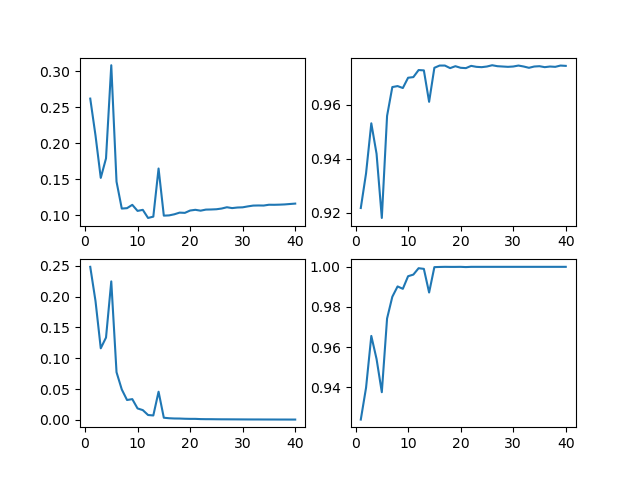

In [15]:
%matplotlib widget
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_loss_list)
axs[0, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_accu_list)
axs[1, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_loss_list)
axs[1, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_accu_list)

In [16]:
#Change the batch size from 128 to 512

# batch chage
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop

epochs = 40
batch_size = 512

n_H1 = 256 # number of neurons in the hidden layer
n_H2 = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

np.random.seed(1127)
W = [1e-1*np.random.randn(n, n_H1), 1e-1*np.random.randn(n_H1, n_H2), 1e-1*np.random.randn(n_H2, K)]
b = [np.random.randn(n_H1)]

vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list = main(epochs, batch_size)

valid: epochs 1
Cross-entropy loss after 1 iterations is 0.39005513
Training accuracy after 1 iterations is 87.9048%
train:
Cross-entropy loss after 1 iterations is 0.3837142
Training accuracy after 1 iterations is 88.0714%
gW0=1.0149 gW1=1.3176 gb0=0.5281
etaW0=0.4961 etaW1=0.4354 etab0=0.6874
|dW0|=0.68910 |dW1|=0.56950 |dW2|=0.61908 |db0|=0.09482 

valid: epochs 11
Cross-entropy loss after 11 iterations is 0.10535817
Training accuracy after 11 iterations is 96.7262%
train:
Cross-entropy loss after 11 iterations is 0.035292061
Training accuracy after 11 iterations is 99.1280%
gW0=0.5289 gW1=0.5231 gb0=0.5153
etaW0=0.6869 etaW1=0.6906 etab0=0.6958
|dW0|=0.21157 |dW1|=0.15511 |dW2|=0.08207 |db0|=0.02069 

valid: epochs 21
Cross-entropy loss after 21 iterations is 0.1005621
Training accuracy after 21 iterations is 97.1310%
train:
Cross-entropy loss after 21 iterations is 0.010003215
Training accuracy after 21 iterations is 99.8899%
gW0=0.5206 gW1=0.5182 gb0=0.5152
etaW0=0.6923 etaW1=0.6

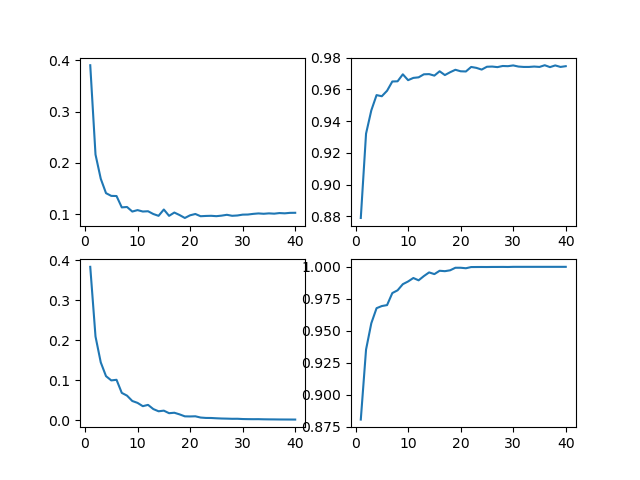

In [17]:
%matplotlib widget
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_loss_list)
axs[0, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_accu_list)
axs[1, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_loss_list)
axs[1, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_accu_list)

In [18]:
#change the combination of the sizes of the hidden layers, set n_H2=512
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
num_iter = 2000 # number of iterations of gradient descent

epochs = 50
batch_size = 128

n_H1 = 256 # number of neurons in the 1st hidden layer
n_H2 = 512 # number of neurons in the 2rd hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

np.random.seed(1128)
W = [1e-1*np.random.randn(n, n_H1), 1e-1*np.random.randn(n_H1, n_H2), 1e-1*np.random.randn(n_H2, K)]
b = [np.random.randn(n_H1)]

vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list = main(epochs, batch_size)

valid: epochs 1
Cross-entropy loss after 1 iterations is 0.18627549
Training accuracy after 1 iterations is 94.5238%
train:
Cross-entropy loss after 1 iterations is 0.15813528
Training accuracy after 1 iterations is 95.4048%
gW0=0.6746 gW1=0.4742 gb0=0.0824
etaW0=0.6083 etaW1=0.7253 etab0=1.7314
|dW0|=0.41999 |dW1|=0.27360 |dW2|=0.19363 |db0|=0.04486 

valid: epochs 11
Cross-entropy loss after 11 iterations is 0.21291849
Training accuracy after 11 iterations is 94.5000%
train:
Cross-entropy loss after 11 iterations is 0.12740966
Training accuracy after 11 iterations is 96.0833%
gW0=0.2440 gW1=0.1538 gb0=0.0738
etaW0=1.0101 etaW1=1.2710 etab0=1.8280
|dW0|=1.01347 |dW1|=0.78120 |dW2|=0.37530 |db0|=0.11363 

valid: epochs 21
Cross-entropy loss after 21 iterations is 0.10008048
Training accuracy after 21 iterations is 97.7857%
train:
Cross-entropy loss after 21 iterations is 0.00020464262
Training accuracy after 21 iterations is 100.0000%
gW0=0.0712 gW1=0.0711 gb0=0.0711
etaW0=1.8614 etaW1

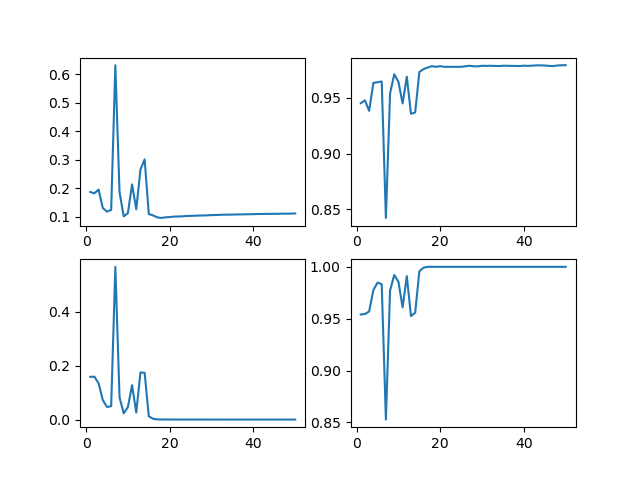

In [19]:
%matplotlib notebook
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_loss_list)
axs[0, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_accu_list)
axs[1, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_loss_list)
axs[1, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_accu_list)

In [20]:
#change the combination of the sizes of the hidden layers, set n_H1=n_H2=512
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
num_iter = 2000 # number of iterations of gradient descent

epochs = 50
batch_size = 128

n_H1 = 512 # number of neurons in the 1st hidden layer
n_H2 = 512 # number of neurons in the 2rd hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

np.random.seed(1128)
W = [1e-1*np.random.randn(n, n_H1), 1e-1*np.random.randn(n_H1, n_H2), 1e-1*np.random.randn(n_H2, K)]
b = [np.random.randn(n_H1)]

vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list = main(epochs, batch_size)

valid: epochs 1
Cross-entropy loss after 1 iterations is 0.21233555
Training accuracy after 1 iterations is 93.6786%
train:
Cross-entropy loss after 1 iterations is 0.19407405
Training accuracy after 1 iterations is 94.1786%
gW0=1.6265 gW1=2.5894 gb0=0.1056
etaW0=0.3919 etaW1=0.3107 etab0=1.5314
|dW0|=0.69236 |dW1|=0.52206 |dW2|=0.48230 |db0|=0.07501 

valid: epochs 11
Cross-entropy loss after 11 iterations is 0.40757986
Training accuracy after 11 iterations is 91.3333%
train:
Cross-entropy loss after 11 iterations is 0.2481679
Training accuracy after 11 iterations is 93.9286%
gW0=0.1599 gW1=0.1075 gb0=0.0723
etaW0=1.2466 etaW1=1.5177 etab0=1.8469
|dW0|=1.14730 |dW1|=0.81427 |dW2|=0.35423 |db0|=0.13892 

valid: epochs 21
Cross-entropy loss after 21 iterations is 0.14184113
Training accuracy after 21 iterations is 97.0238%
train:
Cross-entropy loss after 21 iterations is 0.017735816
Training accuracy after 21 iterations is 99.4524%
gW0=0.1174 gW1=0.0931 gb0=0.0716
etaW0=1.4528 etaW1=1.6

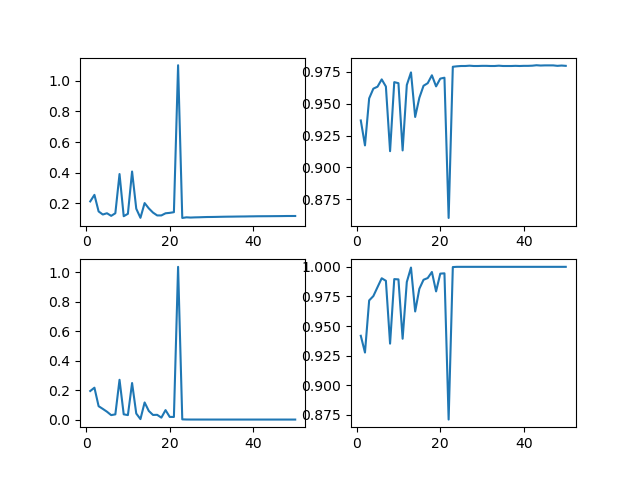

In [21]:
%matplotlib notebook
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_loss_list)
axs[0, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_accu_list)
axs[1, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_loss_list)
axs[1, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_accu_list)

In [22]:
# Change the strength of the regularization, set alpha=1e-5
%%time
# batch chage
eta = 5e-1
alpha = 1e-5 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop

epochs = 40
batch_size = 128

n_H1 = 256 # number of neurons in the hidden layer
n_H2 = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

np.random.seed(1127)
W = [1e-1*np.random.randn(n, n_H1), 1e-1*np.random.randn(n_H1, n_H2), 1e-1*np.random.randn(n_H2, K)]
b = [np.random.randn(n_H1)]

vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list = main(epochs, batch_size)

UsageError: Line magic function `%%time` not found.


In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_loss_list)
axs[0, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_accu_list)
axs[1, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_loss_list)
axs[1, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_accu_list)

In [ ]:
#Change the strength of the regularization, set alpha=1e-2
%%time
# batch chage
eta = 5e-1
alpha = 1e-2 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop

epochs = 40
batch_size = 128

n_H1 = 256 # number of neurons in the hidden layer
n_H2 = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

np.random.seed(1127)
W = [1e-1*np.random.randn(n, n_H1), 1e-1*np.random.randn(n_H1, n_H2), 1e-1*np.random.randn(n_H2, K)]
b = [np.random.randn(n_H1)]

vaild_loss_list, vaild_accu_list, train_loss_list, train_accu_list = main(epochs, batch_size)

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_loss_list)
axs[0, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), vaild_accu_list)
axs[1, 0].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_loss_list)
axs[1, 1].plot(np.arange(1, epochs + 1, 1, dtype=np.int32), train_accu_list)